In [1]:
!sh setup.sh

     |████████████████████████████████| 60.4 MB 1.2 MB/s eta 0:00:01
^C
ERROR: Operation cancelled by user


In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision.io import read_image
import torchvision.transforms.functional as F
import os
import openslide
import math
from tqdm import tqdm
import pandas as pd
import time
from PIL import Image
from scipy.ndimage import morphology
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Create CSV

In [3]:
# This function is used to create the csv file which will be used in dataloader
def CreateCSV(path):
    csv_path = os.path.join(path,'label.csv')
    Filename = os.listdir(path)
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['label','ori'])
        for name in Filename:
            if len(name.split('_'))==2:
                coordinate = name.split('.')[0]
                writer.writerow([name,coordinate+'_ori.png'])

# Cut Patch

In [4]:
class PathError(BaseException):
    pass

In [5]:
# Use openslide to read svs and tif file 
def read_tif(image_path):
    if not os.path.isfile(image_path):
        raise FileNotFoundError
    mr_data = openslide.OpenSlide(image_path)
    return mr_data

In [6]:
def find_tissue(wsi):
    wsi = wsi.read_region((0,0),level,whole_slide_img_ori.level_dimensions[level]).convert('RGB')
    wsi = np.array(wsi)
    patch_gray = cv2.cvtColor(wsi, cv2.COLOR_RGB2GRAY)
    ret, patch_gray = cv2.threshold(patch_gray, 220, 255, cv2.THRESH_BINARY)
    patch_gray = 255- patch_gray
    tissue_region = morphology.binary_fill_holes(patch_gray).astype(np.uint8)
    number_of_tissue_area = np.count_nonzero(tissue_region)
    wsi_new = []
    wsi_t = np.transpose(wsi,(2,0,1)).copy()
    for channel in wsi_t:
        channel[tissue_region==0] = 0
        wsi_new.append(channel)
    wsi_new = np.transpose(wsi_new,(1,2,0))
    
    return wsi_new, number_of_tissue_area

In [15]:
inpath_dir = '/home/jimmy505024/AC/rawdata/NewAnnotation' 
save_path_dir = '/home/jimmy505024/AC/rawdata/trichome/new_patch'
patch_size = 512
level = 2
rate = 2**level
min_ratio = 0.001
threshold = patch_size * patch_size * min_ratio

for filename in os.listdir(inpath_dir):
    if '.tif' in filename:
        # setting input label path (xxxxx.tif)
        inpath_label = os.path.join(inpath_dir, filename)
        
        # setting input original path (xxxxx.svs)
        filename = filename.replace('.tif', '.svs')
        inpath = os.path.join(inpath_dir, filename)
        inpath = inpath.replace('/NewAnnotation/','/ICC/')
        
        # setting save path (D:\XXXX\patch\FILENAME)
        filename = filename.replace('.svs','')
        save_path = os.path.join(save_path_dir, filename)
        print(inpath)
        print(save_path)
        
        # make target directory if it is not existed yet
        if os.path.isdir(save_path):
            # make sure that I don't overwrite the directory 
            raise PathError("Target Directory is already existed. \n{} ".format(save_path))
        else:
            os.makedirs(save_path)

        whole_slide_img_label = read_tif(inpath_label)
        whole_slide_img_ori = read_tif(inpath)
        print(whole_slide_img_label.level_dimensions)
        print(whole_slide_img_ori.level_dimensions)
        width = math.ceil(whole_slide_img_label.level_dimensions[level][0] / patch_size) * patch_size
        height = math.ceil(whole_slide_img_label.level_dimensions[level][1] / patch_size) * patch_size
        
        wsi_ori_new,_ = find_tissue(whole_slide_img_ori)
        wsi_label_new,_ = find_tissue(whole_slide_img_label)

        # x = 96000, y = 65000
        for j in tqdm(range(0,height, patch_size//2)):
            for i in range(0,width,patch_size//2):
                    
                    # read whole_slide_img with coordinate (i,j) and patch size
                    patch_ori = wsi_ori_new[j:j+patch_size,i:i+patch_size,...]
                    patch = wsi_label_new[j:j+patch_size,i:i+patch_size,...]
                    if patch_ori.shape==(512,512,3):
                        patch_ori = cv2.cvtColor(patch_ori, cv2.COLOR_BGR2RGB)
                        patch_ori_gray = cv2.cvtColor(patch_ori, cv2.COLOR_RGB2GRAY)
                        patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)

                        # setting path for output file
                        path = os.path.join(save_path, '{}_{}.png'.format(i,j))
                        path_ori = os.path.join(save_path, '{}_{}_ori.png'.format(i,j))

                        # patch element: background = 0, fibrosis = 1, vascular wall = 2, vessel = 3, inter-background=4 , 

                        patch[patch==4]=0
                        
                        if np.count_nonzero(patch) > threshold:                       
                            cv2.imwrite(path,patch)
                            cv2.imwrite(path_ori,patch_ori)
        CreateCSV(save_path)

/home/jimmy505024/AC/rawdata/ICC/CSY-HM-9a_TRI_icc.svs
/home/jimmy505024/AC/rawdata/trichome/new_patch/CSY-HM-9a_TRI_icc
((93623, 92316), (46811, 46158), (23405, 23079), (11702, 11539), (5851, 5769), (2925, 2884), (1462, 1442), (731, 721), (365, 360))
((93623, 92316), (46811, 46158), (23405, 23079), (11702, 11539), (5851, 5769), (2925, 2884), (1462, 1442), (731, 721), (365, 360), (182, 180))


100%|██████████| 92/92 [00:29<00:00,  3.08it/s]


# Data Loader

In [17]:
path = '/home/jimmy505024/AC/rawdata/trichome/new_patch/'
folder = os.listdir(path)
csv_path = []
img_dir = []
for fold in folder:
    csv_path.append(os.path.join(path,fold,'label.csv'))
    img_dir.append(os.path.join(path,fold))
    
transform = A.Compose([
    A.GaussianBlur(),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    ToTensorV2()
])
    
class MyDataset(data.Dataset):
    
    def __init__(self, img_dir, csv_path,):
        self.csv_list = csv_path
        self.img_dir = img_dir
        self.get_all_data()
    def __len__(self):
        return len(self.img_path_list)
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        label_path = self.label_path_list[index]
        
        img_rgb = Image.open(img_path).convert('RGB')
        image_np = np.array(img_rgb)
        
        labels = Image.open(label_path)
        labels_np = np.array(labels)
        
        transformed = transform(image = image_np, mask = labels_np)
        transformed_img = transformed['image']
        transformed_mask = transformed['mask']
        
        return transformed_img, transformed_mask
    
    def get_all_data(self):
        self.img_path_list = []
        self.label_path_list = []
        for img_dir, csv in zip(self.img_dir, self.csv_list):
            label = pd.read_csv(csv)
            for i in range(len(label)):
                self.img_path_list.append(os.path.join(img_dir, label.iloc[i, 1]))
                self.label_path_list.append(os.path.join(img_dir, label.iloc[i, 0]))
train_set = MyDataset(img_dir=img_dir, csv_path = csv_path)
print('Data number: ', train_set.__len__())
img_loader = DataLoader(dataset=train_set, batch_size=10, shuffle=True, num_workers=1)

Data number:  1206


## Visualize data

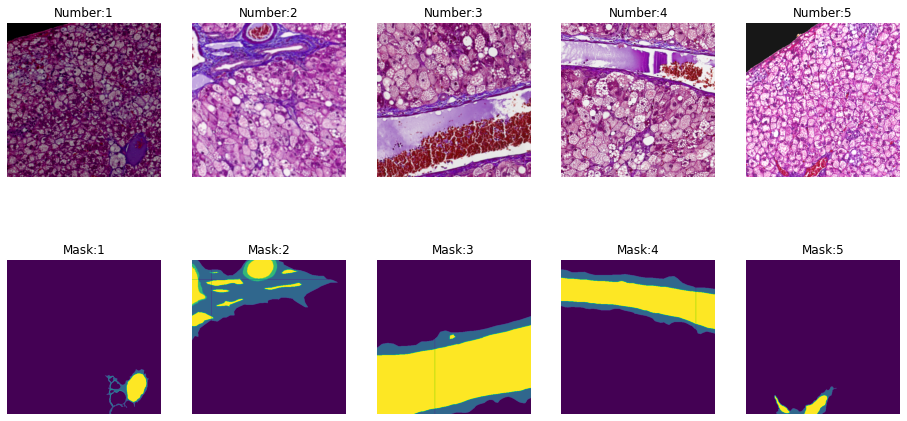

In [19]:
for inputs, labels in img_loader:
    i=0
    plt.figure(figsize=(16,8))
    
    for img,mask in zip(inputs,labels):
        if i<5:
            img = np.transpose(img, (1,2,0))
    #             labels = np.transpose(labels, (1,2,0))
            plt.subplot(2,5,i+1)
            plt.title('Number:{}'.format(i+1))
            plt.imshow(img)
            plt.axis('off')
            plt.subplot(2,5,i+6)
            plt.title('Mask:{}'.format(i+1))
            plt.imshow(mask)
            plt.axis('off')
            i+=1
    plt.show()
    break

# Define Model

In [20]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def createDeepLabv3(outputchannels):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    model.train()
    return model

my_nn = createDeepLabv3(outputchannels=4)
optimizer = optim.Adam(my_nn.parameters(), lr=0.001)

In [21]:
ckp_path = '/home/jimmy505024/AC/0213.ckp'
my_nn.load_state_dict(torch.load(ckp_path))

<All keys matched successfully>

In [22]:
my_nn.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Training Process

In [24]:
from focalloss.focalloss import FocalLoss
criterion = FocalLoss()
Current_Min_Loss = 10
for epoch in range(10000):  # loop over the dataset multiple times
 
    running_loss = 0.0
    cnt = 0
    for inputs, labels in tqdm(img_loader):
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        masks = labels.to(device)       
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = my_nn(inputs)       
        loss = criterion(outputs['out'], masks)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        cnt += 1
    if (running_loss < Current_Min_Loss):
        Current_Min_Loss = running_loss
        best_model = my_nn
    print('Epoch:{}  Loss:{:.3f} Current Min Loss:{:.3f}'.format(epoch+1, running_loss, Current_Min_Loss))
    

print('Finished Training')

  0%|          | 0/121 [00:00<?, ?it/s]/home/jimmy505024/AC/focalloss/focalloss.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:1  Loss:2.075 Current Min Loss:2.075


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:2  Loss:1.544 Current Min Loss:1.544


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:3  Loss:1.381 Current Min Loss:1.381


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:4  Loss:1.359 Current Min Loss:1.359


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:5  Loss:1.279 Current Min Loss:1.279


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:6  Loss:1.315 Current Min Loss:1.279


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:7  Loss:1.157 Current Min Loss:1.157


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:8  Loss:2.566 Current Min Loss:1.157


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:9  Loss:1.388 Current Min Loss:1.157


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:10  Loss:1.215 Current Min Loss:1.157


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:11  Loss:1.196 Current Min Loss:1.157


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:12  Loss:1.137 Current Min Loss:1.137


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:13  Loss:1.138 Current Min Loss:1.137


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:14  Loss:1.062 Current Min Loss:1.062


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:15  Loss:1.028 Current Min Loss:1.028


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:16  Loss:1.036 Current Min Loss:1.028


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:17  Loss:1.045 Current Min Loss:1.028


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:18  Loss:1.084 Current Min Loss:1.028


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:19  Loss:1.038 Current Min Loss:1.028


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:20  Loss:0.992 Current Min Loss:0.992


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:21  Loss:0.990 Current Min Loss:0.990


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:22  Loss:1.000 Current Min Loss:0.990


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:23  Loss:0.976 Current Min Loss:0.976


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:24  Loss:0.975 Current Min Loss:0.975


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:25  Loss:0.981 Current Min Loss:0.975


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:26  Loss:0.945 Current Min Loss:0.945


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:27  Loss:0.929 Current Min Loss:0.929


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:28  Loss:0.925 Current Min Loss:0.925


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:29  Loss:0.924 Current Min Loss:0.924


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:30  Loss:0.908 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:31  Loss:0.910 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:32  Loss:1.252 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:33  Loss:1.109 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:34  Loss:1.004 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:35  Loss:0.997 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:36  Loss:0.934 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:37  Loss:0.910 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:38  Loss:0.917 Current Min Loss:0.908


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:39  Loss:0.899 Current Min Loss:0.899


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:40  Loss:0.904 Current Min Loss:0.899


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:41  Loss:0.877 Current Min Loss:0.877


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:42  Loss:0.897 Current Min Loss:0.877


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:43  Loss:0.953 Current Min Loss:0.877


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:44  Loss:0.881 Current Min Loss:0.877


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:45  Loss:0.872 Current Min Loss:0.872


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:46  Loss:0.863 Current Min Loss:0.863


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:47  Loss:0.866 Current Min Loss:0.863


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:48  Loss:0.878 Current Min Loss:0.863


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:49  Loss:0.858 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:50  Loss:0.867 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:51  Loss:0.862 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:52  Loss:0.877 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:53  Loss:0.864 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:54  Loss:0.858 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:55  Loss:0.858 Current Min Loss:0.858


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:56  Loss:0.855 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:57  Loss:0.860 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:58  Loss:1.561 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:59  Loss:0.995 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:60  Loss:0.912 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:61  Loss:0.879 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:62  Loss:0.863 Current Min Loss:0.855


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:63  Loss:0.849 Current Min Loss:0.849


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:64  Loss:0.841 Current Min Loss:0.841


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:65  Loss:0.843 Current Min Loss:0.841


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:66  Loss:0.838 Current Min Loss:0.838


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:67  Loss:0.834 Current Min Loss:0.834


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:68  Loss:0.837 Current Min Loss:0.834


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:69  Loss:0.822 Current Min Loss:0.822


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:70  Loss:0.818 Current Min Loss:0.818


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:71  Loss:0.820 Current Min Loss:0.818


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:72  Loss:0.810 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:73  Loss:0.813 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:74  Loss:0.815 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:75  Loss:0.856 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:76  Loss:0.824 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:77  Loss:0.825 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:78  Loss:0.818 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:79  Loss:1.025 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:80  Loss:0.952 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:81  Loss:0.853 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:82  Loss:0.833 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:83  Loss:0.821 Current Min Loss:0.810


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:84  Loss:0.805 Current Min Loss:0.805


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:85  Loss:0.943 Current Min Loss:0.805


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:86  Loss:0.936 Current Min Loss:0.805


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:87  Loss:0.845 Current Min Loss:0.805


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:88  Loss:0.821 Current Min Loss:0.805


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:89  Loss:0.808 Current Min Loss:0.805


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:90  Loss:0.803 Current Min Loss:0.803


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:91  Loss:0.801 Current Min Loss:0.801


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:92  Loss:0.794 Current Min Loss:0.794


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:93  Loss:0.792 Current Min Loss:0.792


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:94  Loss:0.812 Current Min Loss:0.792


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:95  Loss:0.794 Current Min Loss:0.792


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:96  Loss:0.798 Current Min Loss:0.792


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:97  Loss:0.781 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:98  Loss:0.795 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:99  Loss:0.789 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:100  Loss:0.782 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:101  Loss:0.785 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:102  Loss:0.792 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:103  Loss:0.784 Current Min Loss:0.781


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:104  Loss:0.779 Current Min Loss:0.779


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:105  Loss:0.778 Current Min Loss:0.778


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:106  Loss:0.776 Current Min Loss:0.776


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:107  Loss:0.771 Current Min Loss:0.771


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:108  Loss:0.774 Current Min Loss:0.771


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:109  Loss:0.765 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:110  Loss:0.778 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:111  Loss:0.813 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:112  Loss:1.304 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:113  Loss:1.123 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:114  Loss:0.957 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:115  Loss:1.576 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:116  Loss:1.174 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:117  Loss:0.923 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:118  Loss:0.870 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:119  Loss:0.870 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:120  Loss:0.853 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:121  Loss:0.813 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:122  Loss:0.800 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:123  Loss:0.796 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:124  Loss:0.788 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:125  Loss:0.788 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:126  Loss:0.781 Current Min Loss:0.765


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:127  Loss:0.768 Current Min Loss:0.765


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:128  Loss:0.764 Current Min Loss:0.764


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:129  Loss:0.774 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:130  Loss:0.770 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:131  Loss:0.766 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:132  Loss:2.497 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:133  Loss:1.192 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:134  Loss:0.969 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:135  Loss:0.894 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:136  Loss:0.850 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:137  Loss:0.836 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:138  Loss:0.814 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:139  Loss:0.805 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:140  Loss:0.808 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:141  Loss:0.791 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:142  Loss:0.807 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:143  Loss:0.785 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:144  Loss:0.775 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:145  Loss:0.776 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:146  Loss:0.766 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:147  Loss:0.764 Current Min Loss:0.764


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:148  Loss:0.760 Current Min Loss:0.760


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:149  Loss:0.757 Current Min Loss:0.757


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:150  Loss:0.755 Current Min Loss:0.755


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:151  Loss:0.752 Current Min Loss:0.752


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:152  Loss:0.764 Current Min Loss:0.752


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:153  Loss:0.755 Current Min Loss:0.752


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:154  Loss:0.751 Current Min Loss:0.751


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:155  Loss:0.753 Current Min Loss:0.751


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:156  Loss:0.746 Current Min Loss:0.746


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:157  Loss:0.745 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:158  Loss:0.746 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:159  Loss:0.747 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:160  Loss:0.747 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:161  Loss:0.747 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:162  Loss:0.747 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:163  Loss:0.756 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:164  Loss:0.756 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:165  Loss:0.755 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:166  Loss:0.750 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:167  Loss:0.746 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:168  Loss:0.752 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:169  Loss:0.752 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:170  Loss:0.748 Current Min Loss:0.745


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:171  Loss:0.743 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:172  Loss:0.915 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:173  Loss:0.796 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:174  Loss:0.767 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:175  Loss:0.752 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:176  Loss:0.744 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:177  Loss:0.743 Current Min Loss:0.743


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:178  Loss:0.741 Current Min Loss:0.741


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:179  Loss:0.743 Current Min Loss:0.741


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:180  Loss:0.739 Current Min Loss:0.739


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:181  Loss:0.736 Current Min Loss:0.736


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:182  Loss:0.814 Current Min Loss:0.736


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:183  Loss:0.785 Current Min Loss:0.736


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:184  Loss:0.746 Current Min Loss:0.736


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:185  Loss:0.744 Current Min Loss:0.736


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:186  Loss:0.736 Current Min Loss:0.736


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:187  Loss:0.731 Current Min Loss:0.731


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:188  Loss:0.734 Current Min Loss:0.731


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:189  Loss:0.731 Current Min Loss:0.731


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:190  Loss:0.733 Current Min Loss:0.731


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:191  Loss:0.730 Current Min Loss:0.730


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:192  Loss:0.733 Current Min Loss:0.730


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:193  Loss:0.740 Current Min Loss:0.730


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:194  Loss:0.732 Current Min Loss:0.730


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:195  Loss:0.728 Current Min Loss:0.728


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:196  Loss:0.729 Current Min Loss:0.728


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:197  Loss:0.724 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:198  Loss:0.726 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:199  Loss:0.730 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:200  Loss:0.730 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:201  Loss:0.730 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:202  Loss:0.737 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:203  Loss:0.817 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:204  Loss:0.754 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:205  Loss:0.741 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:206  Loss:0.727 Current Min Loss:0.724


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:207  Loss:0.721 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:208  Loss:0.722 Current Min Loss:0.721


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:209  Loss:0.732 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:210  Loss:0.962 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:211  Loss:0.851 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:212  Loss:0.776 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:213  Loss:1.376 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:214  Loss:0.918 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:215  Loss:1.221 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:216  Loss:0.856 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:217  Loss:0.792 Current Min Loss:0.721


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:218  Loss:0.772 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:219  Loss:0.759 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:220  Loss:0.753 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:221  Loss:0.740 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:222  Loss:0.738 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:223  Loss:0.735 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:224  Loss:0.724 Current Min Loss:0.721


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:225  Loss:0.720 Current Min Loss:0.720


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:226  Loss:0.728 Current Min Loss:0.720


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:227  Loss:0.725 Current Min Loss:0.720


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:228  Loss:0.728 Current Min Loss:0.720


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:229  Loss:0.718 Current Min Loss:0.718


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:230  Loss:0.709 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:231  Loss:0.712 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:232  Loss:0.709 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:233  Loss:0.709 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:234  Loss:0.718 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:235  Loss:0.712 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:236  Loss:0.709 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:237  Loss:0.709 Current Min Loss:0.709


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:238  Loss:0.705 Current Min Loss:0.705


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:239  Loss:0.704 Current Min Loss:0.704


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:240  Loss:0.707 Current Min Loss:0.704


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:241  Loss:0.703 Current Min Loss:0.703


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:242  Loss:0.705 Current Min Loss:0.703


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:243  Loss:0.706 Current Min Loss:0.703


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:244  Loss:0.716 Current Min Loss:0.703


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:245  Loss:0.704 Current Min Loss:0.703


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:246  Loss:0.704 Current Min Loss:0.703


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:247  Loss:0.701 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:248  Loss:0.702 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:249  Loss:0.704 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:250  Loss:0.706 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:251  Loss:0.723 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:252  Loss:0.713 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:253  Loss:0.750 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:254  Loss:0.713 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:255  Loss:0.707 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:256  Loss:0.710 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:257  Loss:1.003 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:258  Loss:0.888 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:259  Loss:0.759 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:260  Loss:0.737 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:261  Loss:0.722 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:262  Loss:0.713 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:263  Loss:0.704 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:264  Loss:0.702 Current Min Loss:0.701


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:265  Loss:0.700 Current Min Loss:0.700


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:266  Loss:0.696 Current Min Loss:0.696


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:267  Loss:0.694 Current Min Loss:0.694


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:268  Loss:0.697 Current Min Loss:0.694


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:269  Loss:0.694 Current Min Loss:0.694


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:270  Loss:0.687 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:271  Loss:0.692 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:272  Loss:0.696 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:273  Loss:0.694 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:274  Loss:0.690 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:275  Loss:0.687 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:276  Loss:0.698 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:277  Loss:0.694 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:278  Loss:0.688 Current Min Loss:0.687


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:279  Loss:0.685 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:280  Loss:0.687 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:281  Loss:0.691 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:282  Loss:0.688 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:283  Loss:0.692 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:284  Loss:0.693 Current Min Loss:0.685


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:285  Loss:0.693 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:286  Loss:0.694 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:287  Loss:0.691 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:288  Loss:0.694 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:289  Loss:0.693 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:290  Loss:0.692 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:291  Loss:0.703 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:292  Loss:0.694 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:293  Loss:0.701 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:294  Loss:0.693 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:295  Loss:0.696 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:296  Loss:0.686 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:297  Loss:0.688 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:298  Loss:0.688 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:299  Loss:0.731 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:300  Loss:0.745 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:301  Loss:0.718 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:302  Loss:1.415 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:303  Loss:0.949 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:304  Loss:0.794 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:305  Loss:0.754 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:306  Loss:0.728 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:307  Loss:0.716 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:308  Loss:0.708 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:309  Loss:0.700 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:310  Loss:0.691 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:311  Loss:0.693 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:312  Loss:0.691 Current Min Loss:0.685


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:313  Loss:0.684 Current Min Loss:0.684


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:314  Loss:0.683 Current Min Loss:0.683


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:315  Loss:0.678 Current Min Loss:0.678


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:316  Loss:0.676 Current Min Loss:0.676


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:317  Loss:0.676 Current Min Loss:0.676


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:318  Loss:0.674 Current Min Loss:0.674


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:319  Loss:0.675 Current Min Loss:0.674


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:320  Loss:0.673 Current Min Loss:0.673


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:321  Loss:0.671 Current Min Loss:0.671


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:322  Loss:0.671 Current Min Loss:0.671


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:323  Loss:0.674 Current Min Loss:0.671


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:324  Loss:0.670 Current Min Loss:0.670


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:325  Loss:0.673 Current Min Loss:0.670


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:326  Loss:0.670 Current Min Loss:0.670


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:327  Loss:0.669 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:328  Loss:0.672 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:329  Loss:0.669 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:330  Loss:0.670 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:331  Loss:0.670 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:332  Loss:0.670 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:333  Loss:0.672 Current Min Loss:0.669


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:334  Loss:0.667 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:335  Loss:0.675 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:336  Loss:1.403 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:337  Loss:0.835 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:338  Loss:0.864 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:339  Loss:0.751 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:340  Loss:0.723 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:341  Loss:0.713 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:342  Loss:0.707 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:343  Loss:0.695 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:344  Loss:0.686 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:345  Loss:0.683 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:346  Loss:0.678 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:347  Loss:0.678 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:348  Loss:0.676 Current Min Loss:0.667


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:349  Loss:0.676 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:350  Loss:0.673 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:351  Loss:0.672 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:352  Loss:0.671 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:353  Loss:0.667 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:354  Loss:0.667 Current Min Loss:0.667


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:355  Loss:0.664 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:356  Loss:0.667 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:357  Loss:0.666 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:358  Loss:0.667 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:359  Loss:0.668 Current Min Loss:0.664


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:360  Loss:0.666 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:361  Loss:0.665 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:362  Loss:0.670 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:363  Loss:0.672 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:364  Loss:0.669 Current Min Loss:0.664


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:365  Loss:0.668 Current Min Loss:0.664


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:366  Loss:0.663 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:367  Loss:0.669 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:368  Loss:0.742 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:369  Loss:0.686 Current Min Loss:0.663


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:370  Loss:0.674 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:371  Loss:0.669 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:372  Loss:0.669 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:373  Loss:0.666 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:374  Loss:0.664 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:375  Loss:0.669 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:376  Loss:0.666 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:377  Loss:0.664 Current Min Loss:0.663


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:378  Loss:0.661 Current Min Loss:0.661


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:379  Loss:0.662 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:380  Loss:0.666 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:381  Loss:0.664 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:382  Loss:0.663 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:383  Loss:0.682 Current Min Loss:0.661


100%|██████████| 121/121 [04:09<00:00,  2.07s/it]


Epoch:384  Loss:0.674 Current Min Loss:0.661


100%|██████████| 121/121 [04:08<00:00,  2.06s/it]


Epoch:385  Loss:0.678 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:386  Loss:0.672 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:387  Loss:0.669 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:388  Loss:0.665 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:389  Loss:0.663 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:390  Loss:0.665 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:391  Loss:0.665 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:392  Loss:0.661 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:393  Loss:0.665 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:394  Loss:0.669 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:395  Loss:0.695 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:396  Loss:0.695 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:397  Loss:0.673 Current Min Loss:0.661


100%|██████████| 121/121 [04:11<00:00,  2.08s/it]


Epoch:398  Loss:0.663 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:399  Loss:0.662 Current Min Loss:0.661


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:400  Loss:0.660 Current Min Loss:0.660


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:401  Loss:0.763 Current Min Loss:0.660


100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


Epoch:402  Loss:0.842 Current Min Loss:0.660


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:403  Loss:1.955 Current Min Loss:0.660


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:404  Loss:1.819 Current Min Loss:0.660


100%|██████████| 121/121 [04:10<00:00,  2.07s/it]


Epoch:405  Loss:1.058 Current Min Loss:0.660


 14%|█▍        | 17/121 [00:37<03:48,  2.20s/it]


KeyboardInterrupt: 

In [25]:
torch.save(best_model.state_dict(), '0217.ckp')

# Show Test Result

## Run Whole-slide-image

## Parameters

In [8]:
icc_path = '/home/jimmy505024/AC/rawdata/ICC/'
in_path = '/home/jimmy505024/AC/rawdata/ICC/'
out_path = '/home/jimmy505024/AC/predict/Trichome/0217'
resize_ratio = 1
patch_size = 512
resized_patch_size = int(patch_size/resize_ratio)
if os.path.isdir(out_path):
    # make sure that I don't overwrite the directory 
    raise PathError("Target Directory is already existed. \n{} ".format(out_path))
else:
    os.makedirs(out_path)

NameError: name 'save_path' is not defined

In [9]:
def find_tissue_patch(patch):
    patch_gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
    ret, patch_gray = cv2.threshold(patch_gray, 220, 255, cv2.THRESH_BINARY)
    patch_gray = 255- patch_gray
    tissue_region = morphology.binary_fill_holes(patch_gray).astype(np.uint8)
    number_of_tissue_area = np.count_nonzero(tissue_region)
    return tissue_region, number_of_tissue_area

## Testing

In [10]:
best_model = my_nn

In [13]:
level = 2
rate = 2**level
my_nn = best_model
for file in os.listdir(icc_path):
    if '.svs' in file:
        start = time.time()
        out_file = os.path.join(out_path, file).replace('.svs','.png')
        in_file = os.path.join(in_path,file)
        print('Input file: {}\nOutput file: {}'.format(in_file, out_file))
        whole_slide_img = read_tif(in_file)
        
        # set shape of whole slide image
        width = math.ceil(whole_slide_img.level_dimensions[level][0] / patch_size) * patch_size
        height = math.ceil(whole_slide_img.level_dimensions[level][1] / patch_size) * patch_size
        
        # initialize the result/total_mask array with shape resized
        result_shape = np.zeros((int(height / resize_ratio), int(width / resize_ratio)), np.uint8)
        result = cv2.merge((result_shape,result_shape,result_shape))
        total_fibro_mask = result_shape + 255
        
        wsi = whole_slide_img.read_region((0,0),level,whole_slide_img.level_dimensions[level]).convert('RGB')
        wsi = np.array(wsi)
        tissue_region, number_of_tissue_area = find_tissue_patch(wsi)

        wsi_new = []
        wsi_t = np.transpose(wsi,(2,0,1)).copy()
        for channel in wsi_t:
            channel[tissue_region==0] = 0
            wsi_new.append(channel)
        wsi_new = np.transpose(wsi_new,(1,2,0))
        tissue_pedding = np.zeros((height, width),np.uint8)
        tissue_pedding[np.where(tissue_region==1)] = 1
        my_nn.eval()
        with torch.no_grad():
            for j in tqdm(range(0, height, patch_size)):
                for i in range(0, width, patch_size):

                        # read whole_slide_img with coordinate (i,j) and patch size
                        
                        patch = wsi_new[j:j+patch_size,i:i+patch_size,...]
                        patch_trans = np.transpose(patch, (2,0,1))

                        # qwe
                        inputs = torch.tensor(patch_trans, dtype= torch.float)
                        inputs = torch.unsqueeze(inputs, 0)
                        inputs = inputs.to(device)

                        result_new = my_nn(inputs)

                        _,predicted_patch = torch.max(result_new['out'], dim=1)
                        predicted_patch = predicted_patch.cpu()
                        fibrosis_mask = np.resize(predicted_patch, (patch.shape[0], patch.shape[1]))


                        # resize
                        resized_corX = int(i/resize_ratio)
                        resized_corY = int(j/resize_ratio)

                        # get resized original image
                        img_fibro = wsi[j:j+patch_size,i:i+patch_size,...]
                        img_fibro = cv2.resize(img_fibro, (resized_patch_size,resized_patch_size))
                        
                        result[resized_corY:resized_corY+resized_patch_size,resized_corX:resized_corX+resized_patch_size] = img_fibro
                        

                        # get resized total mask
                        fibrosis_mask = fibrosis_mask.astype(np.float32)
                        fibrosis_mask = cv2.resize(fibrosis_mask,(resized_patch_size,resized_patch_size))
                        
                        total_fibro_mask[resized_corY:resized_corY+resized_patch_size,resized_corX:resized_corX+resized_patch_size] = fibrosis_mask
                        
        tissue_region = find_tissue_patch(result)

        total_fibro_mask_new = (total_fibro_mask==1).astype(np.uint8)
        total_fibro_mask_new[tissue_pedding==0]=0
        number_of_fibro_area = np.count_nonzero(total_fibro_mask_new)

        total_vascular_wall_mask = (total_fibro_mask==2).astype(np.uint8)
        total_vascular_wall_mask[tissue_pedding==0]=0
        number_of_vascular_area = np.count_nonzero(total_vascular_wall_mask)
        
        total_vessel_mask = (total_fibro_mask==3).astype(np.uint8)
        total_vessel_mask[tissue_pedding==0]=0
        number_of_vessel_area = np.count_nonzero(total_vessel_mask)
        
        result_BGR = cv2.cvtColor(result,cv2.COLOR_RGB2BGR)

        # Draw fibro with yellow
        contours, hierarchy = cv2.findContours(total_fibro_mask_new,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_BGR,contours,-1,(0,255,255),3)

        # Draw vascular wall with red
        contours, hierarchy = cv2.findContours(total_vascular_wall_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_BGR,contours,-1,(0,0,255),3)

        # Draw vessel with green
        contours, hierarchy = cv2.findContours(total_vessel_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_BGR,contours,-1,(0,255,0),3)
        cv2.imwrite(out_file,result_BGR)
        
        ratio = (number_of_fibro_area-number_of_vascular_area)/(number_of_tissue_area-number_of_vessel_area)*100
        end = time.time()
        hours = int((end-start)/3600)
        mins = int((end-start)/60) - hours*60
        secs = int((end-start)%60)
        print('run time: {} hours, {} minutes and {} seconds'.format(hours,mins,secs))
        print('Ratio: {:.3f}%'.format(ratio))
        print('----------------------------------------------------------------------')

Input file: /home/jimmy505024/AC/rawdata/ICC/CSY-HM-5a_TRI_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/CSY-HM-5a_TRI_icc.png


100%|██████████| 45/45 [01:53<00:00,  2.52s/it]


run time: 0 hours, 3 minutes and 59 seconds
Ratio: 0.821%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/CSY-HM-9a_TRI_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/CSY-HM-9a_TRI_icc.png


100%|██████████| 46/46 [01:53<00:00,  2.47s/it]


run time: 0 hours, 4 minutes and 0 seconds
Ratio: 1.084%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/1011040_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/1011040_icc.png


100%|██████████| 39/39 [02:16<00:00,  3.50s/it]


run time: 0 hours, 4 minutes and 49 seconds
Ratio: 1.573%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/1011038_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/1011038_icc.png


100%|██████████| 34/34 [01:12<00:00,  2.14s/it]


run time: 0 hours, 2 minutes and 38 seconds
Ratio: 1.112%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/CSY-HF-8a_TRI_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/CSY-HF-8a_TRI_icc.png


100%|██████████| 42/42 [01:50<00:00,  2.64s/it]


run time: 0 hours, 3 minutes and 53 seconds
Ratio: 1.104%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/CSY-A-4a_TRI_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/CSY-A-4a_TRI_icc.png


100%|██████████| 45/45 [02:07<00:00,  2.84s/it]


run time: 0 hours, 4 minutes and 29 seconds
Ratio: 2.318%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/CSY-HF-9a_TRI_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/CSY-HF-9a_TRI_icc.png


100%|██████████| 44/44 [01:37<00:00,  2.22s/it]


run time: 0 hours, 3 minutes and 26 seconds
Ratio: 1.082%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/1011042_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/1011042_icc.png


100%|██████████| 39/39 [01:17<00:00,  1.99s/it]


run time: 0 hours, 2 minutes and 45 seconds
Ratio: 1.516%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/1011036_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/1011036_icc.png


100%|██████████| 36/36 [02:38<00:00,  4.41s/it]


run time: 0 hours, 5 minutes and 24 seconds
Ratio: 0.615%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/1011034_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/1011034_icc.png


100%|██████████| 30/30 [02:20<00:00,  4.67s/it]


run time: 0 hours, 4 minutes and 1 seconds
Ratio: 0.885%
----------------------------------------------------------------------
Input file: /home/jimmy505024/AC/rawdata/ICC/CSY-A-8a_TRI_icc.svs
Output file: /home/jimmy505024/AC/predict/Trichome/0214/CSY-A-8a_TRI_icc.png


100%|██████████| 46/46 [02:03<00:00,  2.69s/it]


run time: 0 hours, 3 minutes and 37 seconds
Ratio: 3.425%
----------------------------------------------------------------------
